In [1]:
import os
import numpy as np
import xarray as xr
import typhon
import pyarts

In [2]:
# Resolution settings
res_for_sonde_alt = 100
res_above_sonde = 1000
max_alt = 50_000
interp_transition = 3000  # Interpolation transition zone

# IPFS settings
gateway = "https://ipfs.io"
ipfs_hash = "bafybeicb33v6ohezyhgq5rumq4g7ejnfqxzcpuzd4i2fxnlos5d7ebmi3m"


## Load sonde data

In [3]:
def open_ds(ipfs_hash):
    ds =  (xr.open_dataset(f"{gateway}/ipfs/{ipfs_hash}", engine="zarr")
           .rename({"ta":"t"})
            .reset_coords())
    
    valid = (ds.ta_qc == 0) & (ds.rh_qc == 0) & (ds.p_qc == 0)
    return ds[["sonde_id", "p", "rh", "t", "q"]].where(valid, drop=True)

def remove_non_monotonic_p(ds):
    
    sonde_ids = ds.sonde_id
    ds = ds.where(ds.p.diff(dim="altitude") <0)
    return ds.assign(
        sonde_id= sonde_ids)
    

ds = open_ds(ipfs_hash).pipe(remove_non_monotonic_p)

ds = ds.interpolate_na(dim="altitude")
ds = ds.interpolate_na(dim="altitude", fill_value="extrapolate", max_gap=200)
ds = ds.assign(
    H2O=typhon.physics.specific_humidity2vmr(ds.q)
)

## Reference atmosphere from arts3

In [9]:
pyarts.data.download()
fop = pyarts.recipe.AtmosphericFlux(
    atmospheric_altitude=max_alt - res_for_sonde_alt,
    max_level_step=res_for_sonde_alt
)
atm = fop.get_atmosphere()

In [21]:
ref_atm = xr.Dataset(
    data_vars=dict(
    ),
    coords=dict(
        altitude=("altitude", np.arange(0, max_alt, res_for_sonde_alt)[::-1]),
    ),
    attrs=dict(description="Weather related data."),
)

In [22]:
ref_atm = ref_atm.assign(
    {key: (["altitude"], atm[key]) for key in atm.keys()}
)

In [24]:
ref_atm.to_netcdf("arts3_ref_atm.nc")

## Extend dataset with reference values

In [4]:
ref_atm = xr.open_dataset("arts3_ref_atm.nc")

In [24]:
bins = np.arange(0, ds.altitude.max().values, res_for_sonde_alt )
labels=bins + res_for_sonde_alt / 2
binned = xr.concat([
    ds.interp(altitude=0,
    kwargs={"fill_value": "extrapolate"}),
    ds.groupby_bins('altitude', bins=bins, labels=labels[:-1]).mean('altitude').rename({"altitude_bins":"altitude"})],
                   dim="altitude")
binned = binned.assign(
    sonde_id = ds.sonde_id
)
binned

<xarray.Dataset> Size: 6MB
Dimensions:   (sonde: 1069, altitude: 146)
Coordinates:
  * altitude  (altitude) float64 1kB 0.0 50.0 150.0 ... 1.435e+04 1.445e+04
Dimensions without coordinates: sonde
Data variables:
    sonde_id  (sonde) object 9kB 'db2bef40' 'cfe7a063' ... 'f1a2f085' 'ab47dc72'
    p         (sonde, altitude) float64 1MB 1.012e+05 1.006e+05 ... nan nan
    rh        (sonde, altitude) float64 1MB 0.8655 0.867 0.8958 ... nan nan nan
    t         (sonde, altitude) float64 1MB 296.4 296.0 295.1 ... 207.8 nan nan
    q         (sonde, altitude) float64 1MB 0.01534 0.0151 0.01497 ... nan nan
    H2O       (sonde, altitude) float64 1MB 0.02444 0.02406 0.02386 ... nan nan
Attributes:
    creator_email:  helene.gloeckner@mpimet.mpg.de, theresa.mieslinger@mpimet...
    creator_name:   Helene Gloeckner, Theresa Mieslinger, Nina Robbins
    featureType:    trajectoryProfile
    history:        Level 1 ASPEN processing with Aspen V4.0.2 \nLevel 2 qual...
    keywords:       ORCESTRA, BEACH, Sounding, Dropsondes, Tropics, Atmospher...
    license:        CC-BY-4.0
    platform:       HALO
    project:        ORCESTRA, PERCUSION, MAESTRO
    references:     https://github.com/atmdrops/pydropsonde
    source:         dropsondes
    summary:        This dataset is the Level 3 BEACH dataset. It contains qu...
    title:          BEACH dropsonde dataset (Level 3)

In [28]:
bins = np.arange(0, max_alt, res_above_sonde)
labels=bins + res_above_sonde / 2
ref_binned = ref_atm.groupby_bins('altitude', bins=bins, labels=labels[:-1]).mean('altitude').rename({"altitude_bins":"altitude"})

ref_binned

<xarray.Dataset> Size: 5kB
Dimensions:   (altitude: 49)
Coordinates:
  * altitude  (altitude) float64 392B 500.0 1.5e+03 ... 4.75e+04 4.85e+04
Data variables: (12/13)
    N2        (altitude) float64 392B 0.781 0.781 0.781 ... 0.781 0.781 0.781
    mag_w     (altitude) float64 392B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mag_u     (altitude) float64 392B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    O3        (altitude) float64 392B 3.024e-08 3.255e-08 ... 3.177e-06
    CO2       (altitude) float64 392B 0.00033 0.00033 ... 0.00033 0.00033
    wind_v    (altitude) float64 392B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...        ...
    wind_u    (altitude) float64 392B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    O2        (altitude) float64 392B 0.209 0.209 0.209 ... 0.209 0.209 0.209
    mag_v     (altitude) float64 392B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    H2O       (altitude) float64 392B 0.02238 0.01719 ... 5.898e-06 5.942e-06
    p         (altitude) float64 392B 9.531e+04 8.495e+04 ... 115.9 103.1
    t         (altitude) float64 392B 296.4 290.4 285.5 ... 267.8 269.4 269.9
Attributes:
    description:  Weather related data.

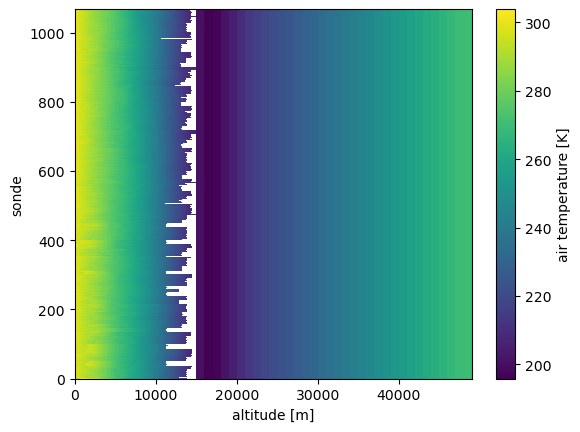

In [65]:
combined_atm = xr.concat(
    [binned, ref_binned.sel(altitude=slice(15000, None))], 
    dim="altitude"
)
combined_atm.t.plot()

In [67]:
bins = np.arange(0, max_alt, res_for_sonde_alt )
labels=bins + res_for_sonde_alt / 2
binned_o3 = xr.concat([
    ref_atm["O3"].interp(altitude=0,
    kwargs={"fill_value": "extrapolate"}),
    ref_atm["O3"].groupby_bins('altitude', bins=bins, labels=labels[:-1]).mean('altitude').rename({"altitude_bins":"altitude"})],
                   dim="altitude")
combined_atm["O3"].loc[{'altitude': slice(0, 14600)}] = binned_o3.sel(altitude=slice(0, 14500))

In [58]:
combined_atm

<xarray.Dataset> Size: 9MB
Dimensions:   (altitude: 180, sonde: 1069)
Coordinates:
  * altitude  (altitude) float64 1kB 0.0 50.0 150.0 ... 4.75e+04 4.85e+04
Dimensions without coordinates: sonde
Data variables: (12/16)
    sonde_id  (altitude, sonde) object 2MB 'db2bef40' 'cfe7a063' ... nan nan
    p         (sonde, altitude) float64 2MB 1.012e+05 1.006e+05 ... 115.9 103.1
    rh        (sonde, altitude) float64 2MB 0.8655 0.867 0.8958 ... nan nan nan
    t         (sonde, altitude) float64 2MB 296.4 296.0 295.1 ... 269.4 269.9
    q         (sonde, altitude) float64 2MB 0.01534 0.0151 0.01497 ... nan nan
    H2O       (sonde, altitude) float64 2MB 0.02444 0.02406 ... 5.942e-06
    ...        ...
    CO2       (altitude) float64 1kB nan nan nan nan ... 0.00033 0.00033 0.00033
    wind_v    (altitude) float64 1kB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    wind_w    (altitude) float64 1kB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    wind_u    (altitude) float64 1kB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    O2        (altitude) float64 1kB nan nan nan nan ... 0.209 0.209 0.209 0.209
    mag_v     (altitude) float64 1kB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    creator_email:  helene.gloeckner@mpimet.mpg.de, theresa.mieslinger@mpimet...
    creator_name:   Helene Gloeckner, Theresa Mieslinger, Nina Robbins
    featureType:    trajectoryProfile
    history:        Level 1 ASPEN processing with Aspen V4.0.2 \nLevel 2 qual...
    keywords:       ORCESTRA, BEACH, Sounding, Dropsondes, Tropics, Atmospher...
    license:        CC-BY-4.0
    platform:       HALO
    project:        ORCESTRA, PERCUSION, MAESTRO
    references:     https://github.com/atmdrops/pydropsonde
    source:         dropsondes
    summary:        This dataset is the Level 3 BEACH dataset. It contains qu...
    title:          BEACH dropsonde dataset (Level 3)

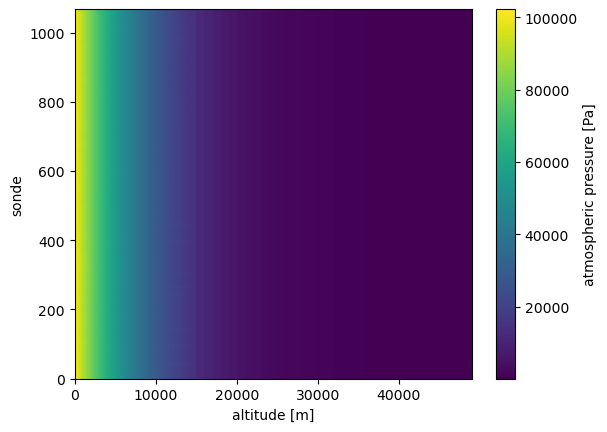

In [68]:
combined_atm = combined_atm.assign(sonde_id=ds.sonde_id)
combined_atm = combined_atm.interpolate_na(dim="altitude", fill_value="extrapolate")
combined_atm.p.plot()


## Save Output

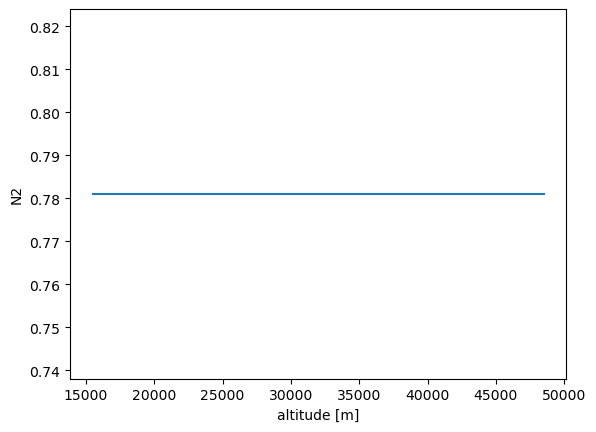

In [56]:
combined_atm.N2.plot()

In [69]:
combined_atm = combined_atm.assign(
    CO2=xr.where(combined_atm.CO2, 422e-6, np.nan)
)

In [71]:
combined_atm.to_netcdf("/work/mh0066/m301046/ml_clouds/sondes_for_radiation.nc")